<a href="https://colab.research.google.com/github/IsaacFigNewton/Analyzing-Hate-Crime-Data/blob/main/Hate_Crime_Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Stuff

###Import all libraries

In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re

###Import datasets

In [2]:
crime_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/hate_crime/hate_crime.csv", on_bad_lines='skip')
city_demo_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/demographics/city/ACSST1Y2022.S0101-Data.csv", on_bad_lines='skip')
county_demo_df = pd.read_csv("https://raw.githubusercontent.com/IsaacFigNewton/Analyzing-Hate-Crime-Data/main/demographics/county/ACSDP1Y2022.DP05-Data.csv", on_bad_lines='skip')

#Data Cleaning

In [3]:
#only consider 2022 crime data from cities and counties
crime_df = crime_df[(crime_df['data_year'] == 2022) & ((crime_df['agency_type_name'] == "City") | (crime_df['agency_type_name'] == "County"))]

In [4]:
# use the entries of the first row as the column headers for easier management
def fixHeaders(df):
  new_headers = df.iloc[0]
  new_df = df[1:]
  new_df.columns = new_headers
  return new_df

In [5]:
#fix the headers
city_demo_df = fixHeaders(city_demo_df)
county_demo_df = fixHeaders(county_demo_df)

In [6]:
def split_area_name(area):
    result = [np.nan, np.nan, np.nan]
    if ", " in area:
        result = area.split(", ") + [np.nan]
    if " city" in result[0].lower():
        result[0] = result[0][0:-5]
        result[2] = result[1]
        result[1] = "City"
    elif " county" in result[0].lower():
        result[0] = result[0][0:-7]
        result[2] = result[1]
        result[1] = "County"

    return result + [np.nan] * (3 - len(result))

def splitArea(df):
    df[["pug_agency_name", "agency_type_name", "state_name"]] = df["Geographic Area Name"].map(split_area_name).apply(pd.Series)

In [7]:
splitArea(city_demo_df)
splitArea(county_demo_df)

# city_demo_df.head()

In [8]:
def split_incident_date(date):
    result = date.split("-")

    return result + [np.nan] * (3 - len(result))

crime_df[["data_year", "incident_month", "incident_day"]] = crime_df["incident_date"].map(split_incident_date).apply(pd.Series)

In [9]:
def fix_columns(df):
  removalList = {"SEX AND AGE!!", "SEX AND ", "Estimate!!", "Total!!", "Total population!!", "CITIZEN, VOTING AGE POPULATION!!", "AGE!!"}

  new_cols = []
  for col in df.columns:
    col = str(col)
    for term in removalList:
      if term in col:
        col = col.replace(term, "")
    new_cols.append(col)

  return new_cols

county_demo_df.columns = fix_columns(county_demo_df)
city_demo_df.columns = fix_columns(city_demo_df)

In [10]:
def preprocess_city_df(df_s0101):
    formatted_df = df_s0101.copy(deep=True)

    formatted_df['25 to 34 years'] = df_s0101['25 to 29 years'] + df_s0101['30 to 34 years']
    formatted_df['35 to 44 years'] = df_s0101['35 to 39 years'] + df_s0101['40 to 44 years']
    formatted_df['45 to 54 years'] = df_s0101['45 to 49 years'] + df_s0101['50 to 54 years']
    formatted_df['65 to 74 years'] = df_s0101['65 to 69 years'] + df_s0101['70 to 74 years']
    formatted_df['75 to 84 years'] = df_s0101['75 to 79 years'] + df_s0101['80 to 84 years']

    return formatted_df

city_demo_df = preprocess_city_df(city_demo_df)
# city_demo_df

###Combine the datasets

In [11]:
# Create new columns that combine data shared between all the city and county entries
overlapping_columns = set(city_demo_df.columns).intersection(set(county_demo_df.columns))
print(overlapping_columns)
demo_df = pd.concat([city_demo_df[list(overlapping_columns)],county_demo_df[list(overlapping_columns)]])

{'Percent!!60 to 64 years', '15 to 19 years', '65 to 74 years', '55 to 59 years', 'agency_type_name', 'Margin of Error!!20 to 24 years', 'Margin of Error!!5 to 9 years', 'Percent!!15 to 19 years', 'Margin of Error!!85 years and over', 'nan', 'Total population', 'state_name', 'Margin of Error!!60 to 64 years', 'Margin of Error!!Under 5 years', 'Percent!!5 to 9 years', 'Margin of Error!!55 to 59 years', 'Percent!!Total population', 'Percent!!10 to 14 years', 'pug_agency_name', '35 to 44 years', 'Percent!!Under 5 years', '20 to 24 years', 'Percent!!20 to 24 years', '5 to 9 years', '45 to 54 years', '10 to 14 years', 'Geography', '75 to 84 years', '60 to 64 years', 'Margin of Error!!15 to 19 years', 'Margin of Error!!10 to 14 years', '25 to 34 years', 'Percent!!55 to 59 years', 'Percent!!85 years and over', 'Geographic Area Name', 'Margin of Error!!Total population', 'Under 5 years', '85 years and over'}


In [26]:
# combine the crime and population datasets
merged_df = pd.merge(crime_df, demo_df, on=["pug_agency_name", "agency_type_name", "state_name"])

###Clean the merged dataset

In [28]:
merged_df.drop(["ori", "state_abbr", "population_group_code", "pub_agency_unit",
                "nan", "Geography", "Percent!!Total population", "population_group_description",
                "Geographic Area Name", "incident_date", "pub_agency_unit"], axis=1, inplace=True)
merged_df.drop(list(merged_df.filter(regex = "Margin of Error")), axis = 1, inplace = True)

In [63]:
merged_df = merged_df.replace("(X)", np.nan)

In [70]:
# Convert object columns to string dtype
object_columns = ["pug_agency_name", "agency_type_name", "state_name", "division_name", "offender_race",
                  "offender_ethnicity", "offense_name", "location_name", "bias_desc", "victim_types", "multiple_offense",
                  "multiple_bias"]
merged_df[object_columns] = merged_df[object_columns].astype(str)

# Number columns
int_columns = ["Total population", "Under 5 years", "5 to 9 years", "45 to 54 years", "10 to 14 years", "75 to 84 years", "60 to 64 years",
                      "25 to 34 years", "15 to 19 years", "20 to 24 years", "35 to 44 years", "55 to 59 years", "65 to 74 years",
                      "85 years and over", "incident_month", "incident_day"]
merged_df[int_columns] = merged_df[int_columns].astype(int)

# Convert columns with percentage values to float
percentage_columns = ["Percent!!60 to 64 years", "Percent!!15 to 19 years", "Percent!!5 to 9 years", "Percent!!10 to 14 years",
                      "Percent!!Under 5 years", "Percent!!20 to 24 years", "Percent!!55 to 59 years", "Percent!!85 years and over"]
merged_df[percentage_columns] = merged_df[percentage_columns].astype(float)

merged_df.dtypes

incident_id                     int64
data_year                      object
pug_agency_name                object
agency_type_name               object
state_name                     object
division_name                  object
region_name                    object
adult_victim_count            float64
juvenile_victim_count         float64
total_offender_count            int64
adult_offender_count          float64
juvenile_offender_count       float64
offender_race                  object
offender_ethnicity             object
victim_count                    int64
offense_name                   object
total_individual_victims      float64
location_name                  object
bias_desc                      object
victim_types                   object
multiple_offense               object
multiple_bias                  object
incident_month                  int64
incident_day                    int64
Percent!!60 to 64 years       float64
15 to 19 years                  int64
65 to 74 yea

# Explore the Data

##Individual Datasets

###Hate Crime Dataset

In [71]:
pd.set_option('display.max_columns', 50)

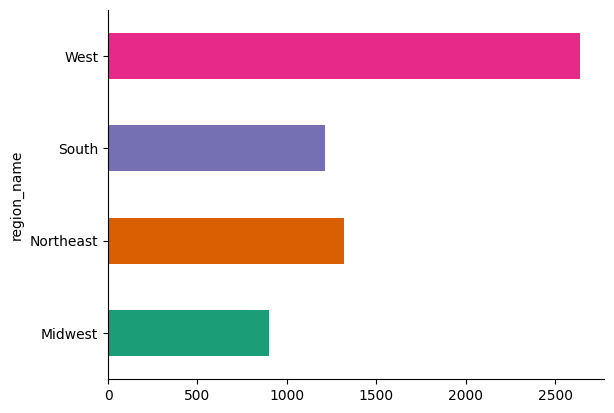

In [72]:
merged_df.groupby('region_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

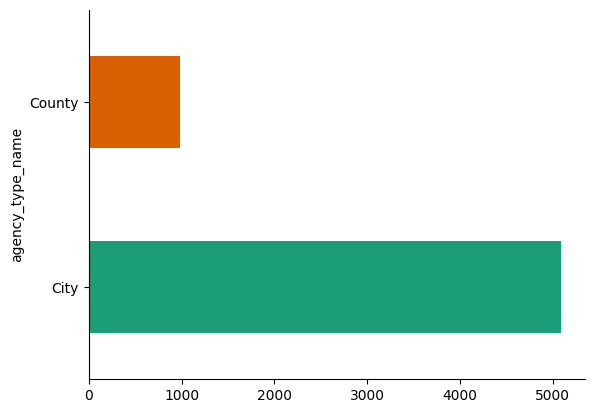

In [73]:
merged_df.groupby('agency_type_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

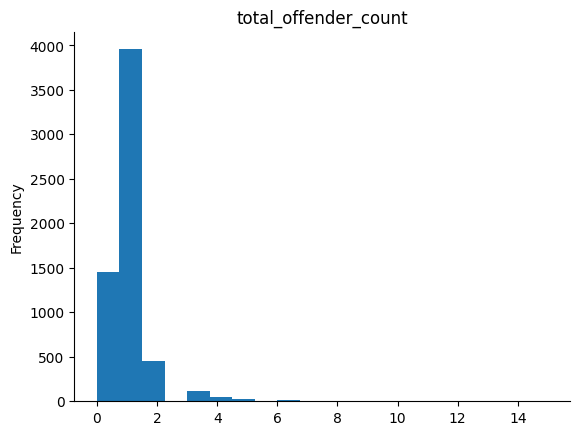

In [74]:
merged_df['total_offender_count'].plot(kind='hist', bins=20, title='total_offender_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

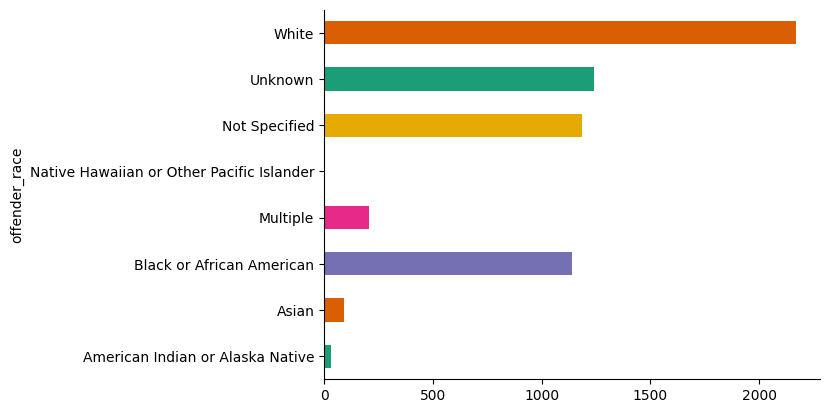

In [75]:
merged_df.groupby('offender_race').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

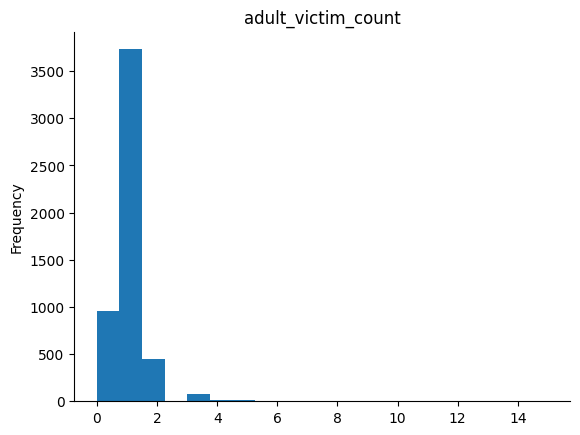

In [76]:
merged_df['adult_victim_count'].plot(kind='hist', bins=20, title='adult_victim_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

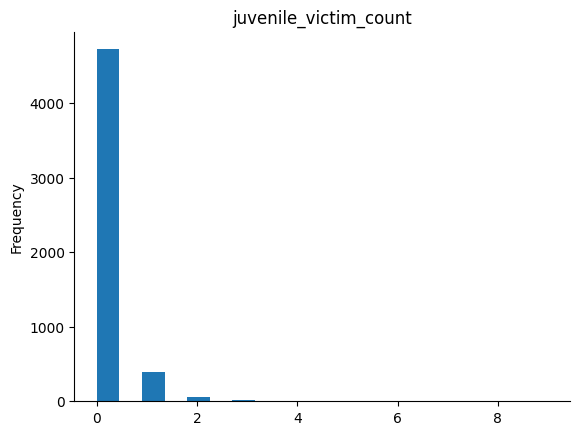

In [77]:
merged_df['juvenile_victim_count'].plot(kind='hist', bins=20, title='juvenile_victim_count')
plt.gca().spines[['top', 'right',]].set_visible(False)

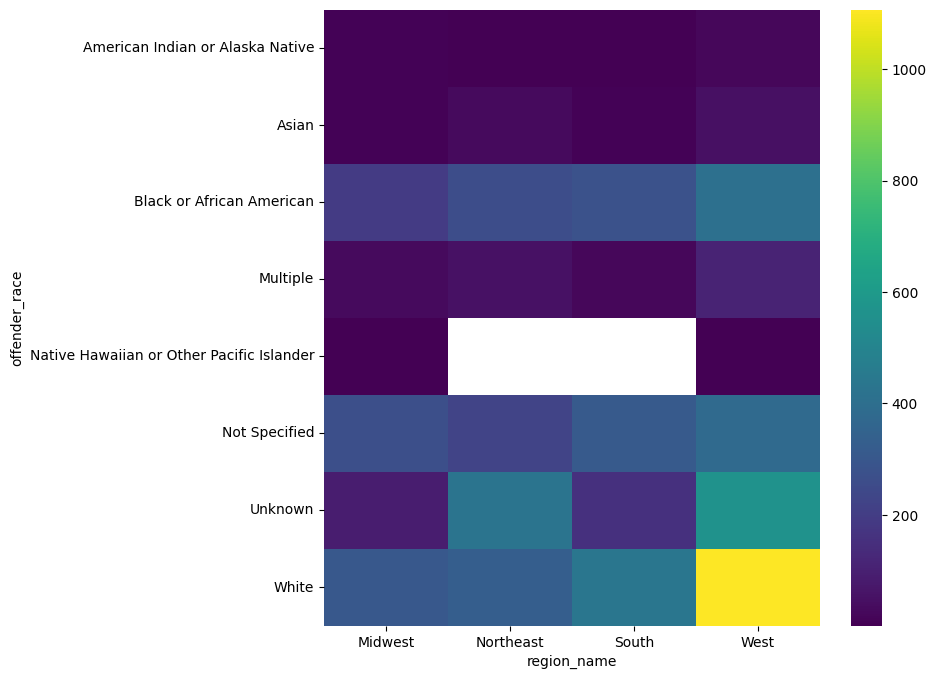

In [78]:
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['offender_race'].value_counts()
    for x_label, grp in merged_df.groupby('region_name')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('region_name')
_ = plt.ylabel('offender_race')

In [79]:
# Select only the numerical columns
numerical_cols = merged_df.select_dtypes(include=['int64', 'float64', np.number]).drop(labels=["incident_id"], axis=1)
# numerical_cols

###City Demographics Dataset

In [ ]:
city_demo_df

###County Demographics Dataset

In [ ]:
county_demo_df

##Merged Dataset

In [ ]:
merged_df.head()

<Axes: >

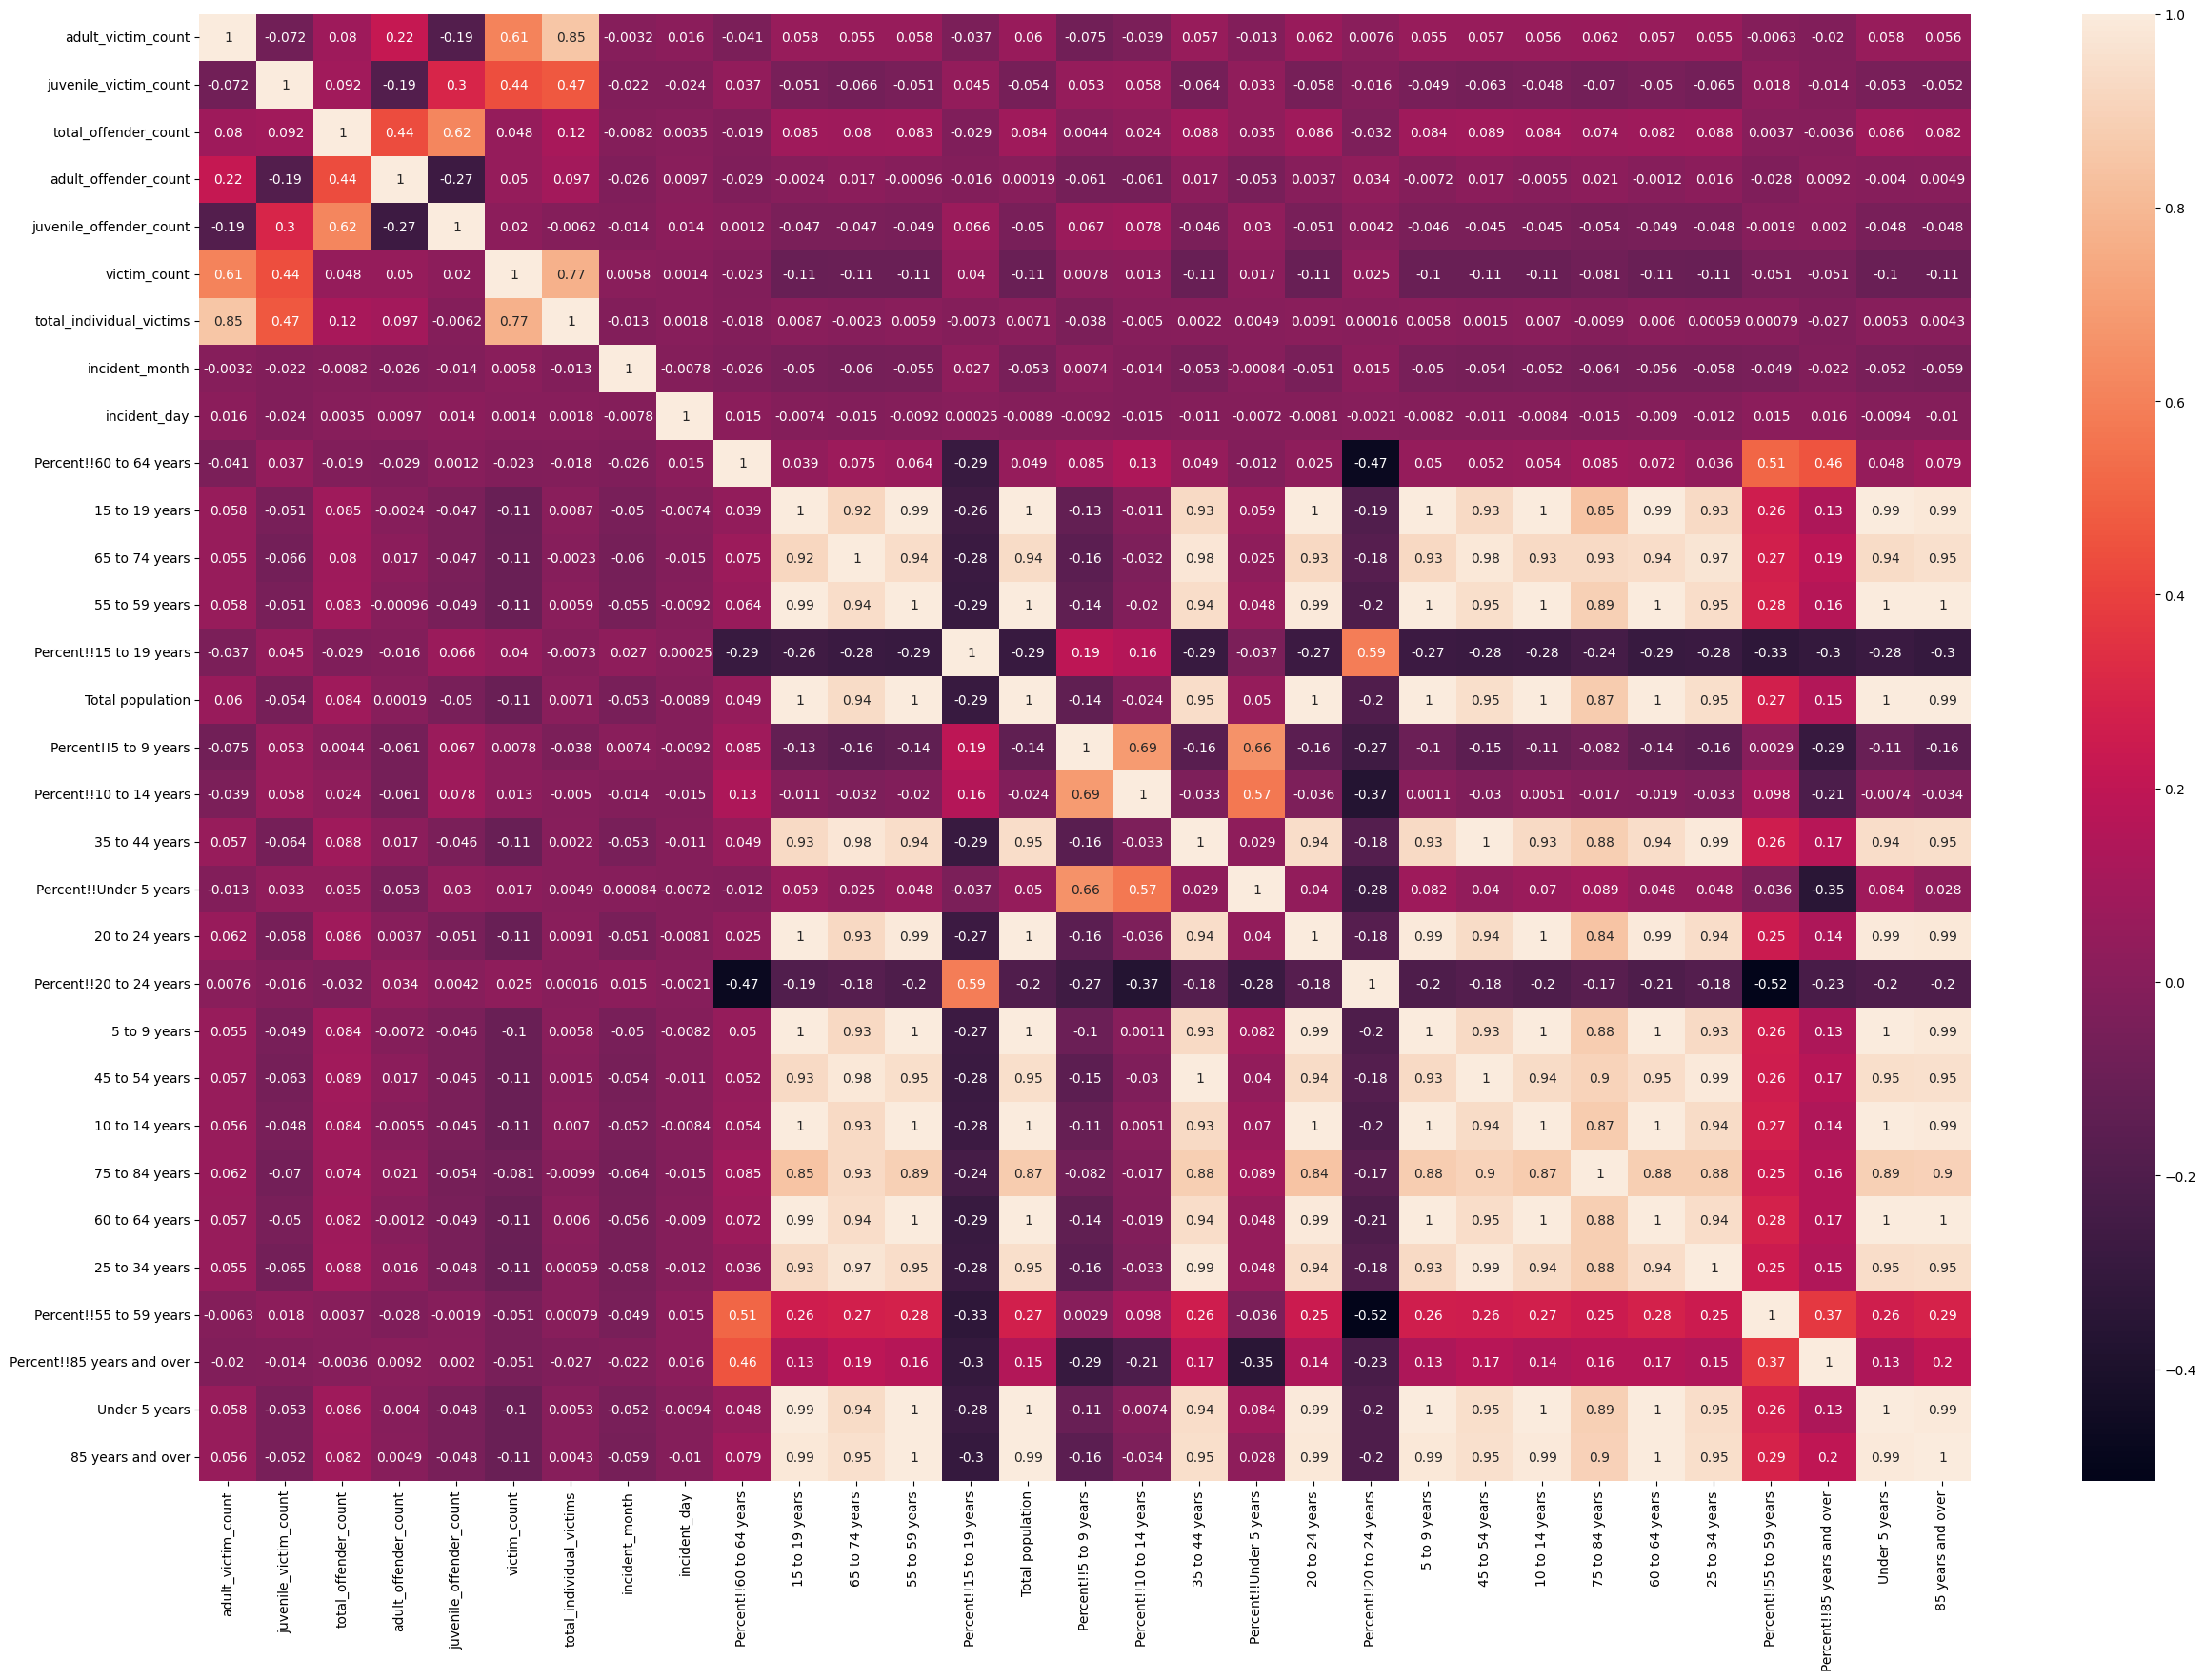

In [86]:
# Create a correlation matrix
corr = merged_df[numerical_cols.columns].corr()

# Create a heatmap of the correlation matrix
fig, ax = plt.subplots(figsize=(30,20))
sns.heatmap(corr, annot=True, ax=ax)